# Лабораторная работа №1: Первичное исследование данных

## 1. Постановка задачи

### Описание данных
Датасет содержит почасовые данные об аренде велосипедов за определенный период. Включает информацию о дате, погодных условиях (сезон, температура, влажность, ветер) и типах дней (праздничные/рабочие). Главная переменная - количество арендованных велосипедов (`count`).

### Условный заказчик
Сервис велопроката или департамент городского транспорта.

### Возможные задачи ИАД
1. **Прогнозирование спроса:** Предсказание количества велосипедов (`count`) для оптимизации их распределения по станциям.
2. **Поиск аномалий:** Выявление дней с неестественно низким спросом (возможные сбои системы) или аномально высоким спросом (мероприятия, праздники).
3. **Профилирование поведения:** Анализ влияния погоды на разные категории пользователей.

## 2. Паспорт датасета

### 2.1. Загрузка данных

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/bikes_dirty.csv')
print("Данные загружены.")

print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")

print("\nПервые 5 строк:")
display(df.head())

Данные загружены.
Размер датасета: 10936 строк, 12 столбцов

Первые 5 строк:


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1.0,9.84,14.395,250.0,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1.0,9.02,13.635,80.0,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1.0,9.02,13.635,80.0,NaN,5,27,32
3,2011-01-01 03:00:00,1,0,0,1.0,9.84,14.395,75.0,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1.0,9.84,14.395,75.0,0.0,0,1,1


### 2.2. Структура данных

In [20]:
# Информация о столбцах и типах
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10936 entries, 0 to 10935
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10936 non-null  object 
 1   season      10936 non-null  int64  
 2   holiday     10936 non-null  int64  
 3   workingday  10936 non-null  int64  
 4   weather     10391 non-null  float64
 5   temp        10936 non-null  float64
 6   atemp       10936 non-null  float64
 7   humidity    9817 non-null   float64
 8   windspeed   10614 non-null  float64
 9   casual      10936 non-null  int64  
 10  registered  10936 non-null  int64  
 11  count       10936 non-null  int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 1.0+ MB


**Вывод по типам:**
- `datetime`: временная метка.
- `season`, `weather`: закодированы числами, по смыслу - категориальные.
- `holiday`, `workingday`: бинарные.
- `temp`, `atemp`, `humidity`, `windspeed`: количественные непрерывные.
- `casual`, `registered`, `count`: количественные дискретные (целые числа)
- Есть признаки с пропусками.

## 3. Аудит качества данных

### 3.1. Пропуски

In [21]:
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_table = pd.concat([missing_data, missing_percent], axis=1, keys=['Total Missing', 'Percent (%)'])
missing_table = missing_table[missing_table['Total Missing'] > 0].sort_values('Percent (%)', ascending=False)

display(missing_table)

,Total Missing,Percent (%)
humidity,1119,10.232260
weather,545,4.983541
windspeed,322,2.944404


**Вывод по пропускам:**
1. **Наиболее проблемный признак:** `humidity` (Влажность). Пропущено **1119 значений**, что составляет **10.23%** от всего датасета. Простое удаление строк с пропусками приведет к потере 1/10 части выборки. Рекомендуется заполнение медианным значением.
2. **Умеренные пропуски:**
   - `weather` (Погода): **4.98%** (545 строк). Так как признак категориальный, пропуски лучше всего заполнить модой.
   - `windspeed` (Скорость ветра): **2.94%** (322 строки). Доля мала, не окажет критического влияния.
3. **Общее состояние:** Пропуски есть как в числовых, так и в категориальных признаках. Необходима стратегия заполнения перед обучением моделей.

### 3.2. Дубликаты

In [22]:
duplicates_count = df.duplicated().sum()
print(f"Количество полных дубликатов строк: {duplicates_count}")

# Проверка дубликатов по времени
time_duplicates = df.duplicated(subset=['datetime']).sum()
print(f"Дубликаты по времени (datetime): {time_duplicates}")

Количество полных дубликатов строк: 50
Дубликаты по времени (datetime): 50


### 3.3. Типические проблемы значений

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10936.0,2.506584,1.115773,1.00,2.0000,3.000,4.0000,4.0000
holiday,10936.0,0.028987,0.167777,0.00,0.0000,0.000,0.0000,1.0000
workingday,10936.0,0.680322,0.466373,0.00,0.0000,1.000,1.0000,1.0000
weather,10391.0,1.419113,0.633654,1.00,1.0000,1.000,2.0000,4.0000
temp,10936.0,20.232915,7.795027,0.82,13.9400,20.500,26.2400,41.0000
atemp,10936.0,23.657563,8.479119,0.76,16.6650,24.240,31.0600,45.4550
humidity,9817.0,61.915453,19.314763,0.00,47.0000,62.000,77.0000,250.0000
windspeed,10614.0,12.800656,8.155415,0.00,7.0015,12.998,16.9979,56.9969
casual,10936.0,36.009967,49.943663,0.00,4.0000,17.000,49.0000,367.0000
registered,10936.0,155.418892,151.011931,0.00,36.0000,118.000,222.0000,886.0000


**Статистический анализ и аномалии:**
1. **Ошибка данных:** Максимальное значение влажности (`humidity`) составляет **250.0**. Физически относительная влажность не может превышать 100%.
2. **Целевая переменная (`count`):** Наблюдается сильное смещение: среднее (191) значительно больше медианы (145).
3. **Ветер:** Минимальная скорость ветра 0. Скорее всего это означает отсутствие измерений.

### 3.4. Выбросы

Границы выбросов для 'count': [-319.50, 644.50]
Количество выбросов: 310


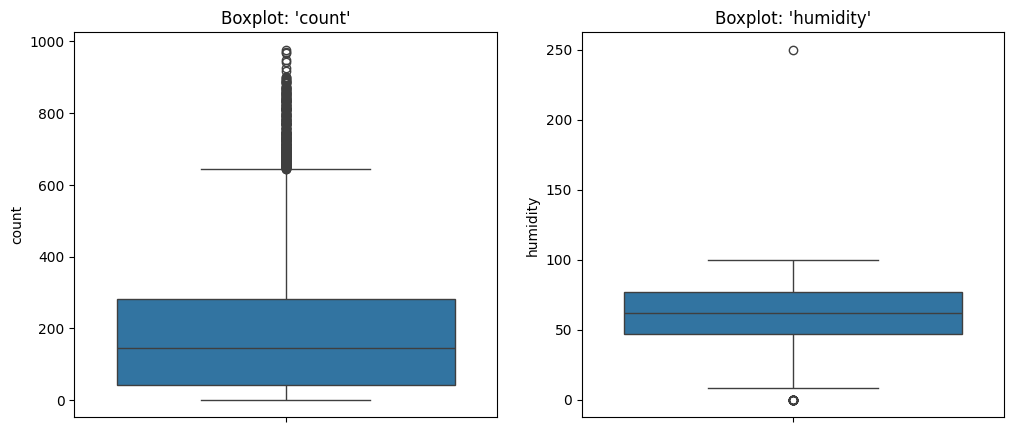

In [24]:
# Анализ выбросов для 'count'
Q1 = df['count'].quantile(0.25)
Q3 = df['count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['count'] < lower_bound) | (df['count'] > upper_bound)]
print(f"Границы выбросов для 'count': [{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"Количество выбросов: {len(outliers)}")

# Визуализация
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['count'])
plt.title("Boxplot: 'count'")

plt.subplot(1, 2, 2)
sns.boxplot(y=df['humidity'])
plt.title("Boxplot: 'humidity'")
plt.show()

**Вывод по выбросам:**
Метод межквартильного размаха определил верхнюю границу нормальных значений на уровне **644.5**.
В зону выбросов `count` попало **310 наблюдений**. Все выбросы находятся в значениях выше верхней границы.
Наблюдения не являются отражают часы пиковой нагрузки, которые важно учитывать при моделировании (например, используя логарифмирование целевой переменной).

## 4. Разведочный анализ

### 4.1. Распределение числового признака

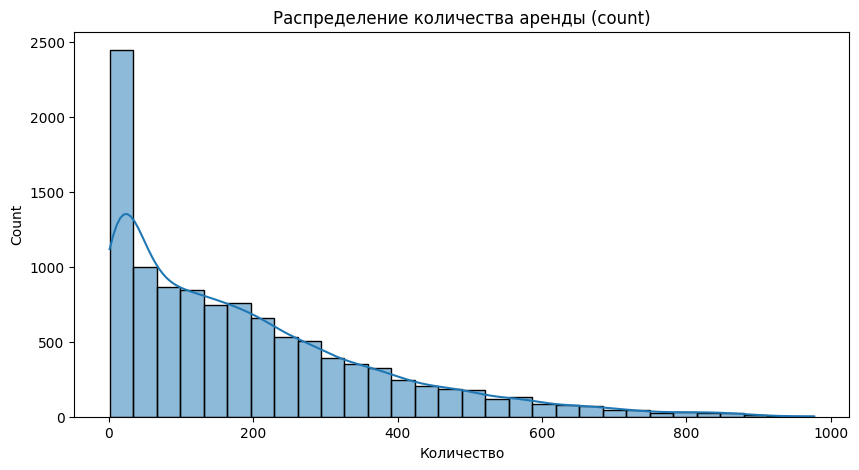

In [26]:
# Распределение целевой переменной
plt.figure(figsize=(10, 5))
sns.histplot(df['count'], kde=True, bins=30)
plt.title('Распределение количества аренды (count)')
plt.xlabel('Количество')
plt.show()

**Анализ распределения `count`:**
- **Что видно:** Распределение имеет сильную правостороннюю асимметрию. Большинство значений сосредоточено в диапазоне от 0 до 200.
- **Что видно:** Это распределение типично для счетных данных. Низкие значения соответствуют ночным часам, а "хвост" - часам пик.
- **Вопрос:** Стоит ли применить логарифмирование целевой переменной перед обучением линейных моделей, чтобы приблизить распределение к нормальному?

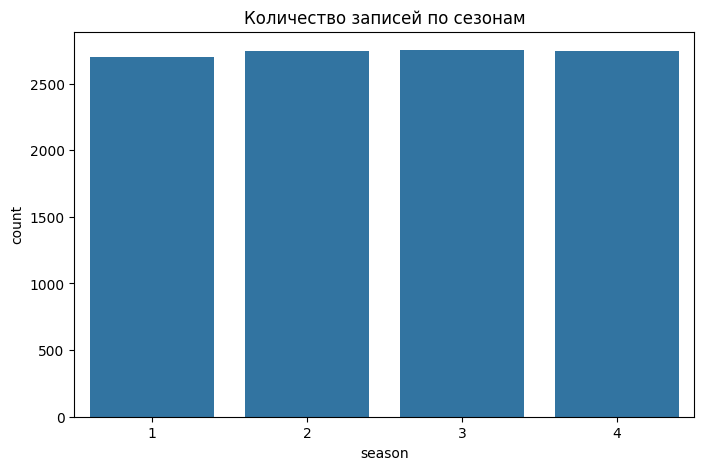

In [27]:
# Распределение категориального признака
plt.figure(figsize=(8, 5))
sns.countplot(x='season', data=df)
plt.title('Количество записей по сезонам')
plt.show()

**Анализ категориального признака `season`:**
- **Что видно:** Количество записей распределено между четырьмя сезонами практически равномерно.
- **Гипотеза:** Данные собирались непрерывно в течение двух лет, без значительных перерывов в какой-либо сезон.
- **Вопрос:** Нет ли скрытого дисбаланса (например, пропущенных дней в конкретном месяце)?

### 4.2. Взаимосвязи

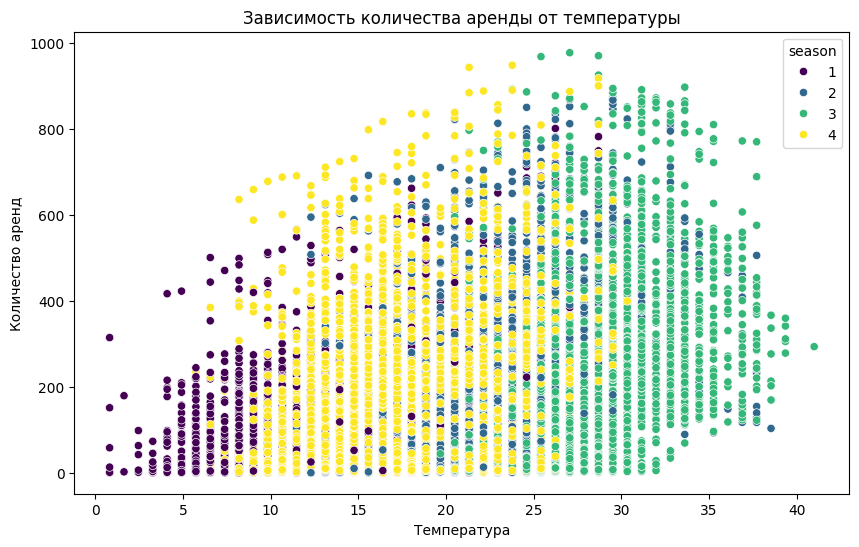

In [28]:
# Зависимость аренды от температуры
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp', y='count', data=df, hue='season', palette='viridis')
plt.title('Зависимость количества аренды от температуры')
plt.xlabel('Температура')
plt.ylabel('Количество аренд')
plt.show()

**Анализ зависимости (Температура и Аренда):**
- **Что видно:** Наблюдается положительная корреляция - с ростом температуры количество аренд увеличивается. "Облако" точек поднимается вверх при движении слева направо.
- **Гипотеза:** Люди охотнее берут велосипеды в теплую погоду. Однако при слишком высоких температурах (>35°C) рост может замедляться.
- **Вопрос:** Видны ли четкие границы между сезонами? Да, сезон 1 сосредоточен в зоне низких температур и низкого спроса, а сезоны 2 и 3 - в зоне высоких температур и высокого спроса.

### 5. Выводы
Детали в файле report/quality_report.md